In [ ]:
#connect to nfldb and load gameStats dataframe
import nfldb
import pandas as pd
import pickle
import math
import urllib2
from lxml import etree
from bs4 import BeautifulSoup
from urllib import urlopen
import numpy as np
import pandas as pd
import collections
import matplotlib.pyplot as plt
import matplotlib
%matplotlib inline
import numpy as np
from scipy.stats.stats import pearsonr 

plt.rcParams['figure.figsize'] = (20.0, 16.0)


db = nfldb.connect()
gameStats = pd.read_csv('gameStats_withFeats_v2.csv')

In [2]:
#Get list of all teams
team_list = gameStats['Team'].unique()

#Fix JAC->JAX issue, and add LA, remove St. Louis
team_list = [team.replace('JAC', 'JAX') for team in team_list]
team_list.append("LA")
team_list.remove("STL")

In [3]:
df_2016 = pd.DataFrame(columns=['PlayerID','Player','Position','Team','Season','Week'])

current_row=0

for team in team_list:
    
    #Go to the nfl page for that team
    web_add = 'http://www.nfl.com/teams/roster?team=%s' % team
    web_html = urlopen(web_add).read()
    soup = BeautifulSoup(web_html)
    
    #Get all of html
    table= soup.find("table", { "id" : "result"} )
    rows=table.findAll('tr',{"class" : ['odd', 'even']})

    #For each player, get relevant info and search for player_id in nfldb
    for row in rows:
        
        #Get name
        names=row.text.split('\n')[2].split(' ')
        first_name=str(names[-1])
        last_name=str(names[-2].split(',')[0])
        full_name = first_name + ' ' + last_name
        
        #Get position
        position = row.text.split('\n')[3]

        #Get bday (for verifying duplicate names)
        bday = row.text.split('\n')[7]
        
        #Get player_id from nfldb
        #By default, assume we have no previous data on the player
        player_id=None
        
        #Query the db for a player id
        q = nfldb.Query(db)
        q.player(full_name=full_name)
        for info in q.as_players():
            if info.birthdate == bday:
                player_id=info.player_id
          
        #Convert back from JAX -> JAC
        if team=='JAX':
            team_name='JAC'
        else:
            team_name=team
        
        df_2016.loc[current_row]=[player_id,full_name,position,team_name,8,120]
        current_row+=1

/Users/richardknoche/anaconda/envs/py27/lib/python2.7/site-packages/bs4/__init__.py:166: UserWarning: No parser was explicitly specified, so I'm using the best available HTML parser for this system ("lxml"). This usually isn't a problem, but if you run this code on another system, or in a different virtual environment, it may use a different parser and behave differently.

To get rid of this warning, change this:

 BeautifulSoup([your markup])

to this:

 BeautifulSoup([your markup], "lxml")

  markup_type=markup_type))


# Fill in stat information from DB

Should really put the 'gameStats_withFeats_v2.csv' file into a MySQL or PostGRE database.  Then update these functions to query the database.  Then each week, run the code above to add each team's current players to the database in a new row (with empty stats), and fill in the previous' weeks data using nfldb.

In [4]:
#Fill in previous season's fantasy points
def FindSeasonScore(row,seasons_prior):
    player=row['Player']
    player_id=row['PlayerID']
    season = row['Season']-seasons_prior
    tot_points = gameStats[(gameStats['Player']==player) & (gameStats['PlayerID']==player_id) & \
              (gameStats['Season']==season)]['FantasyPoints'].sum()
        
    return tot_points

df_2016['PriorSeasonPoints']=df_2016.apply(FindSeasonScore,args=[1] ,axis=1)
df_2016['TwoPriorSeasonPoints']=df_2016.apply(FindSeasonScore,args=[2] ,axis=1)

#Fill in the player's average fantasy stats
def FindPlayerAverage(row,num_weeks,opp=None):
    #Finds average stats of a player over the last num_weeks
    #Can specify and opponent to determine average against a specific opponent
    #Ignored weeks where the player had zero stats (assuming they didn't play)
    player=row['Player']
    player_id=row['PlayerID']
    current_week=row['Week']
    
    start_week = current_week - num_weeks

    #Only use games against the opponent
    if opp:
        means = gameStats[(gameStats['Player']==player) & \
                  (gameStats['PlayerID']==player_id) & \
                  (gameStats['Week']>=start_week) & \
                  (gameStats['NoStats']==False) & \
                  (gameStats['Opponent']==opp) & \
                  (gameStats['Week']<current_week)].ix[:,'passing_yds':'FantasyPoints'].mean()

    else:
        means = gameStats[(gameStats['Player']==player) & \
                  (gameStats['PlayerID']==player_id) & \
                  (gameStats['Week']>=start_week) & \
                  (gameStats['NoStats']==False) & \
                  (gameStats['Week']<current_week)].ix[:,'passing_yds':'FantasyPoints'].mean()
        
    return means


num_weeks=8
avgStats = df_2016.apply(FindPlayerAverage,args=[num_weeks],axis=1)
avgStats.columns = [('%s_%dweekAvg' % (column,num_weeks)) for column in avgStats.columns]
df_2016 = pd.concat([df_2016,avgStats],axis=1)

num_weeks=17
avgStats = df_2016.apply(FindPlayerAverage,args=[num_weeks],axis=1)
avgStats.columns = [('%s_%dweekAvg' % (column,num_weeks)) for column in avgStats.columns]
df_2016 = pd.concat([df_2016,avgStats],axis=1)

num_weeks=34
avgStats = df_2016.apply(FindPlayerAverage,args=[num_weeks],axis=1)
avgStats.columns = [('%s_%dweekAvg' % (column,num_weeks)) for column in avgStats.columns]
df_2016 = pd.concat([df_2016,avgStats],axis=1)

#Not filling in team average or opponent average since they aren't useful

# Load our prediction models (only have WR atm)

In [5]:
modeled_positions=['WR','QB','RB','TE']

In [6]:
from sklearn.externals import joblib
import cPickle


for pos in modeled_positions:

    #Load the models
    exec ("%s_predictor = joblib.load('%s_predictor.pickle')" % (pos,pos))

    #Load the feature lists
    exec ("%s_feature_list = cPickle.load(open('%s_feature_list.pickle', 'rb'))" % (pos,pos))

    #Load the feature scaling info
    exec ("%s_featMinMax = cPickle.load(open('%s_feature_minmax.pickle', 'rb'))" % (pos,pos))


In [7]:
#Feature Scaling
def scaleFeat(featFrame,feat_list,pos):
    
    #player feats
    for feat in feat_list:
        min_feat, max_feat = eval('%s_featMinMax[feat]' % pos)
        featFrame[feat]= (featFrame[feat] - min_feat)/(max_feat-min_feat)
        
    return featFrame

def FillPredictions(row):
    position=row['Position']
    
    if position in modeled_positions:
        features = row[eval('%s_feature_list' % position)]
        if True in [math.isnan(entry) for entry in features]:
            return None
        else:
            scaleFeat(features,eval('%s_feature_list' % position),position)   
            exec("prediction = %s_predictor.predict(features.reshape(1,-1))[0]" % position)
            return prediction
    
    #Don't have predictors for other classes at the moment
    else:
        return None

df_2016['PredictedPoints']=df_2016.apply(FillPredictions,axis=1)

#for week-by-week, will need to make this sum over games in the season
#then add current_predictions*remaining weeks
#For now... just add current_prediction*16

df_2016['PredictedSeasonPoints']=df_2016['PredictedPoints']*16

# Plot the results


In [21]:
def PlotSeasonPrediction(pos,num_players):
    
    has_pred = df_2016['PredictedSeasonPoints'].apply(lambda x: not math.isnan(x))

    season_ranking = df_2016[(has_pred) & (df_2016['Position']==pos)].sort(['PredictedSeasonPoints'],ascending=[False]).reset_index()

    predicted_points = season_ranking['PredictedSeasonPoints'].tolist()
    predicted_points = [points for points in predicted_points if not math.isnan(points)]
    ranks = range(len(predicted_points))
    players = season_ranking['Player'].tolist()
    players = players[:len(predicted_points)]

    from sklearn.cluster import KMeans
    reduced_data= np.array(zip(predicted_points,ranks))
    kmeans = KMeans(n_clusters=10,random_state=10)
    kmeans.fit(reduced_data)


    current_color=kmeans.labels_[0]
    new_color=max(kmeans.labels_)+1
    final_colors=[]
    for color in kmeans.labels_:
        if color==current_color:
            final_colors.append(new_color)
        else:
            current_color = color
            new_color=new_color+1
            final_colors.append(new_color)

    norm = matplotlib.colors.Normalize(vmin=min(final_colors), vmax=max(final_colors), clip=True)
    colors=matplotlib.cm.ScalarMappable(norm=norm, cmap=matplotlib.cm.spectral).to_rgba(final_colors)

    plt.scatter(predicted_points[:num_players],ranks[:num_players],c=colors[:num_players])
    plt.xlabel("Predicted Fantasy Points",size=40)
    plt.ylabel("Rank",size=40)
    plt.title("2016 %s Predictions (PPR)" % pos,size=40)
    plt.ylim([-5,num_players+1])
    plt.xlim([predicted_points[num_players]*0.9,predicted_points[0]*1.15])

    ax = plt.subplot() # Defines ax variable by creating an empty plot

    # Set the tick labels font
    for label in (ax.get_xticklabels() + ax.get_yticklabels()):
        label.set_fontname('Arial')
        label.set_fontsize(25)
    
    for idx, player in enumerate(players[:num_players]):
        plt.annotate(player, (predicted_points[idx]+2,ranks[idx]), va='center', size=14, color=colors[idx])

    plt.gca().invert_yaxis()
    plt.grid()
    plt.show()
    
plt.rcParams['figure.figsize'] = (20.0, 16.0)


/Users/richardknoche/anaconda/envs/py27/lib/python2.7/site-packages/ipykernel/__main__.py:5: FutureWarning: sort(columns=....) is deprecated, use sort_values(by=.....)


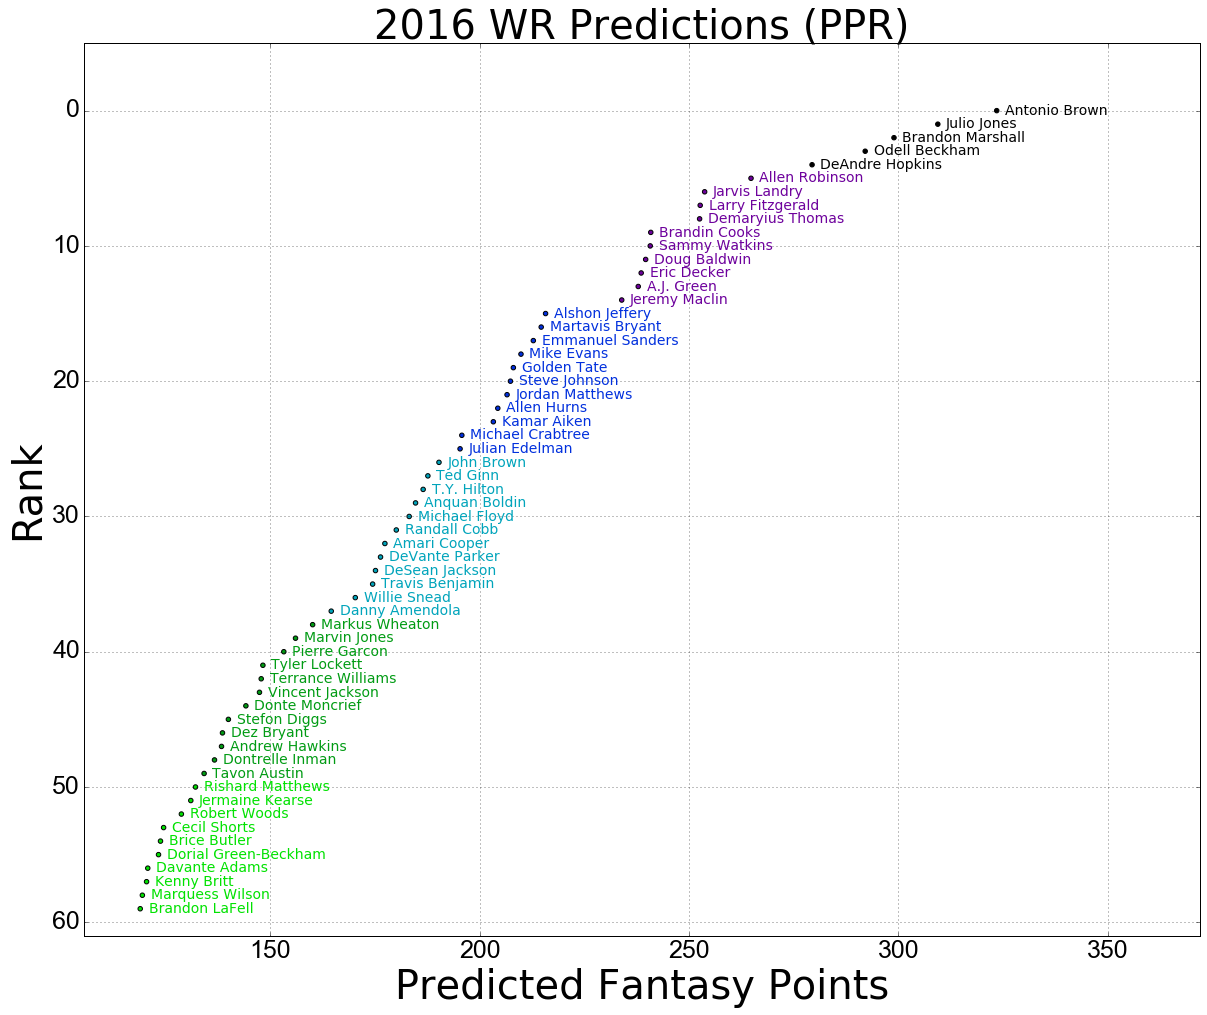

In [22]:
PlotSeasonPrediction('WR',60)

/Users/richardknoche/anaconda/envs/py27/lib/python2.7/site-packages/ipykernel/__main__.py:5: FutureWarning: sort(columns=....) is deprecated, use sort_values(by=.....)


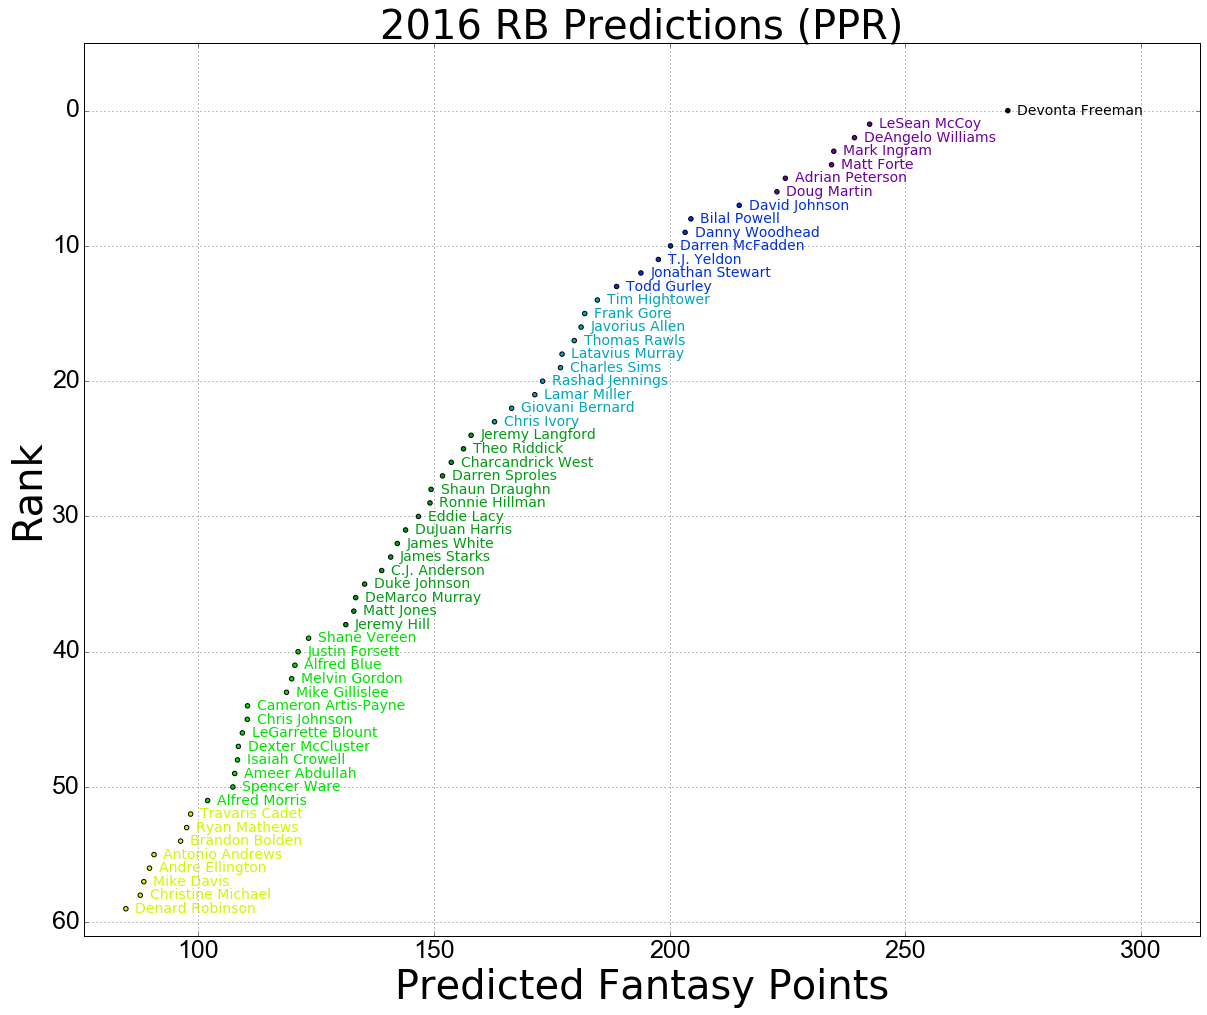

In [23]:
PlotSeasonPrediction('RB',60)

/Users/richardknoche/anaconda/envs/py27/lib/python2.7/site-packages/ipykernel/__main__.py:5: FutureWarning: sort(columns=....) is deprecated, use sort_values(by=.....)


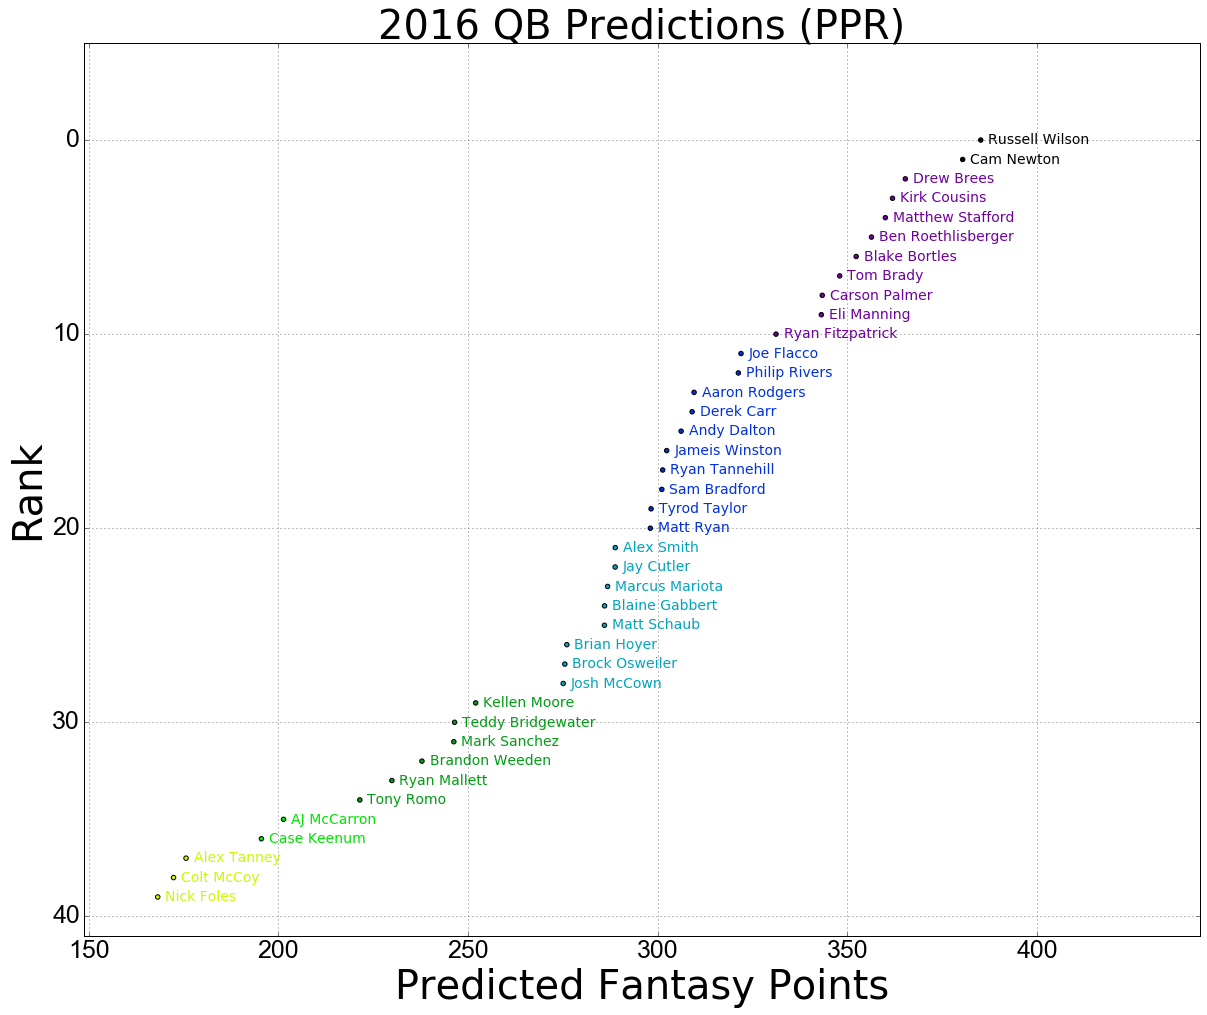

In [24]:
PlotSeasonPrediction('QB',40)

/Users/richardknoche/anaconda/envs/py27/lib/python2.7/site-packages/ipykernel/__main__.py:5: FutureWarning: sort(columns=....) is deprecated, use sort_values(by=.....)


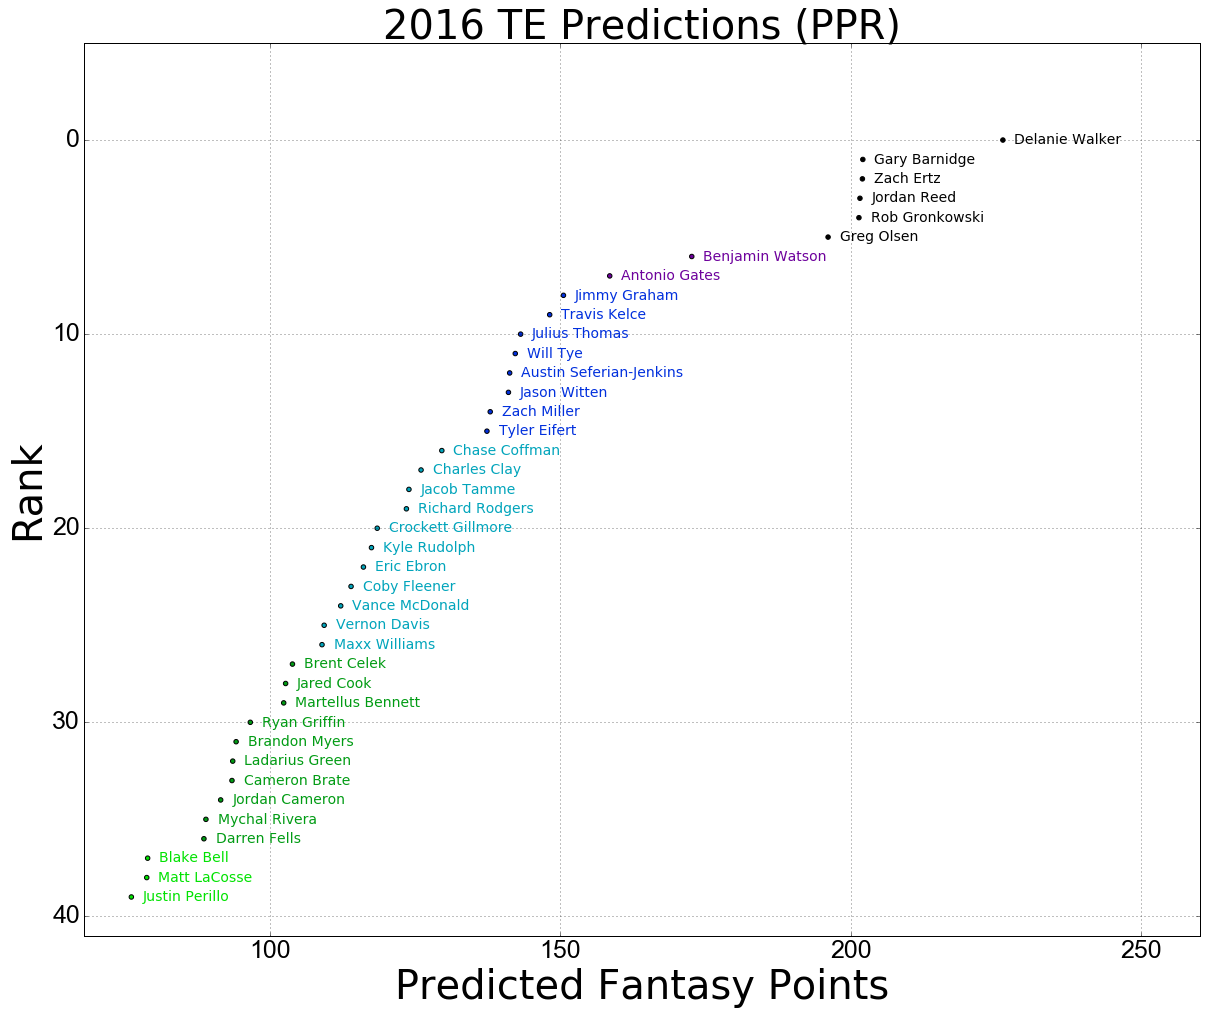

In [25]:
PlotSeasonPrediction('TE',40)

# Show all flex players at once

/Users/richardknoche/anaconda/envs/py27/lib/python2.7/site-packages/ipykernel/__main__.py:8: FutureWarning: sort(columns=....) is deprecated, use sort_values(by=.....)


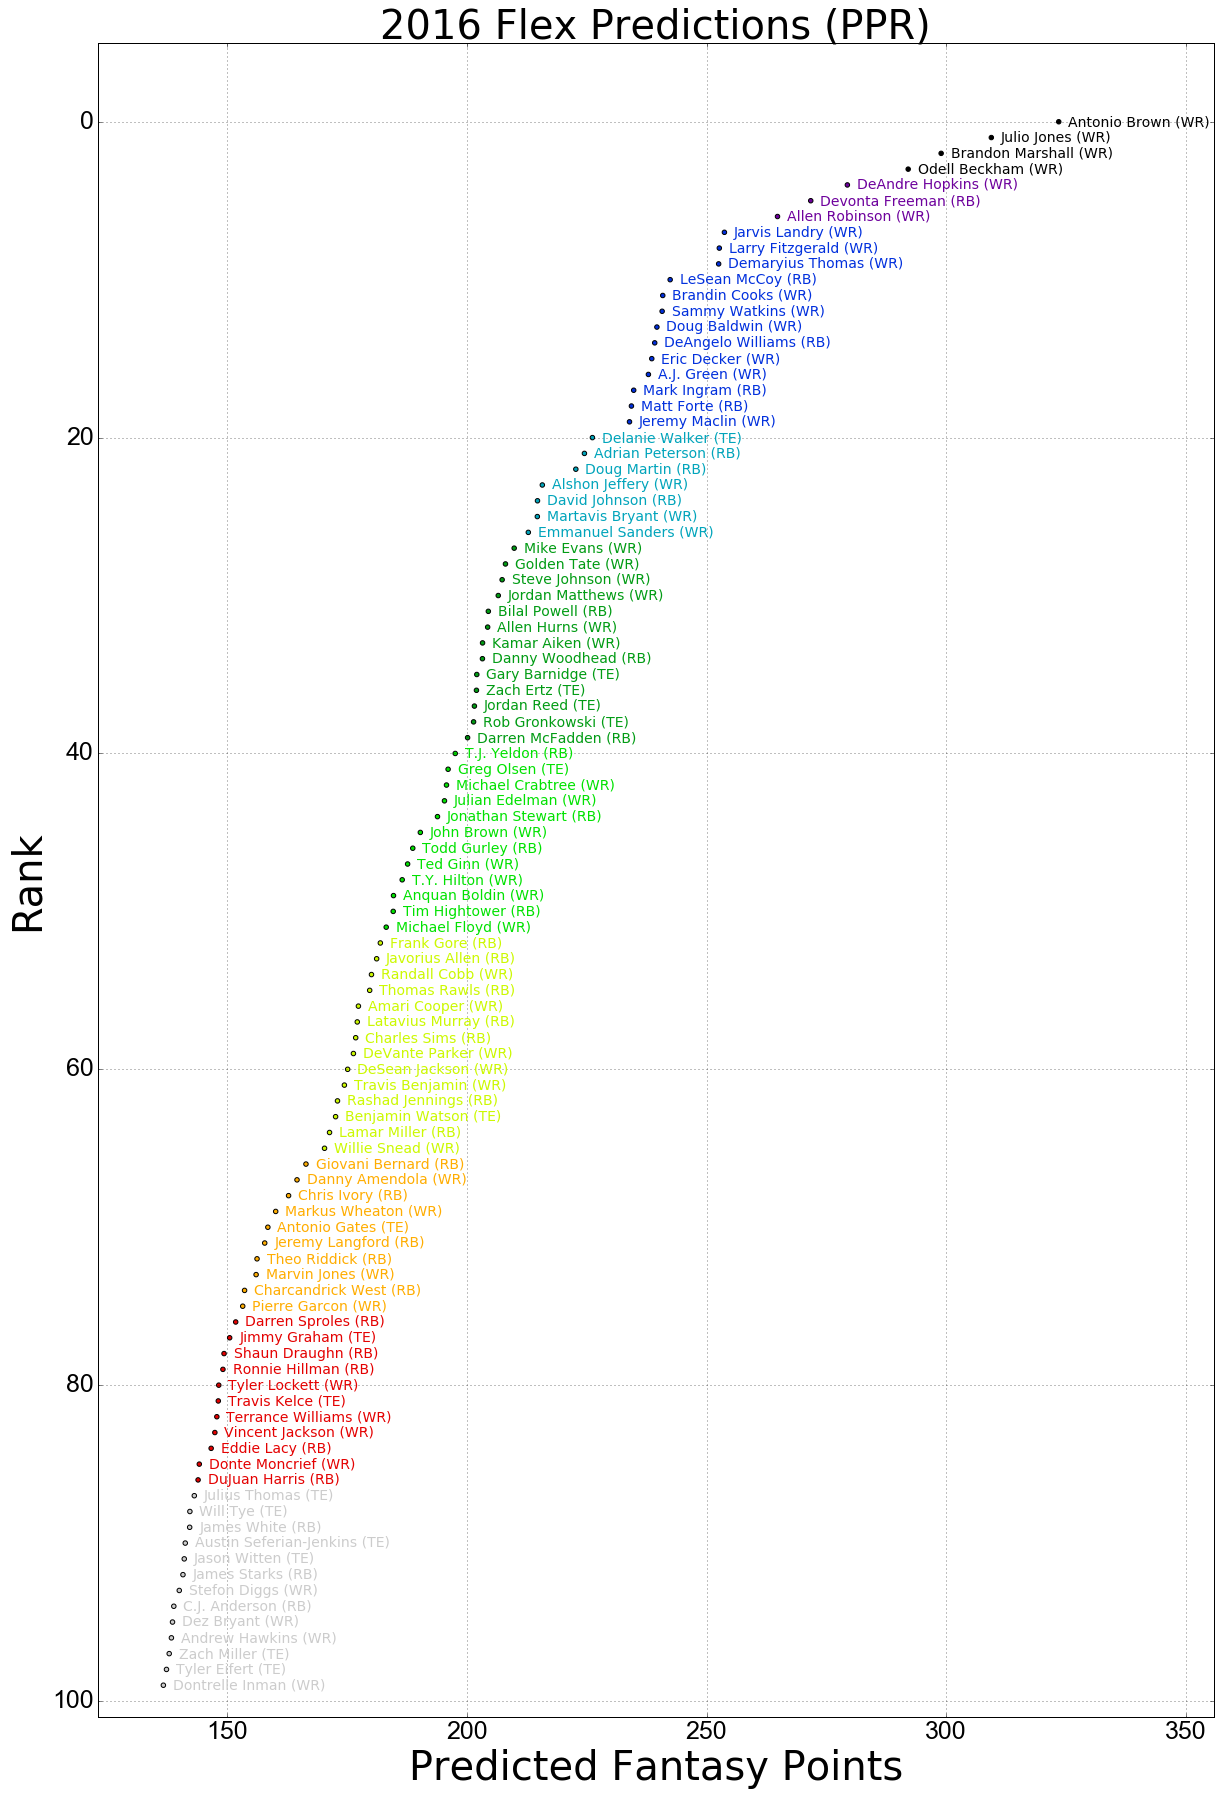

In [16]:
plt.rcParams['figure.figsize'] = (20.0, 30.0)


def PlotAllSeasonPrediction(num_players):
    
    has_pred = df_2016['PredictedSeasonPoints'].apply(lambda x: not math.isnan(x))

    season_ranking = df_2016[(has_pred) & (df_2016['Position']!="QB")].sort(['PredictedSeasonPoints'],ascending=[False]).reset_index()

    predicted_points = season_ranking['PredictedSeasonPoints'].tolist()
    predicted_points = [points for points in predicted_points if not math.isnan(points)] #drop nan at end
    ranks = range(len(predicted_points))
    players = season_ranking['Player'].tolist()
    positions = season_ranking['Position'].tolist()
    players = players[:len(predicted_points)] #nan was at end of predicted points, so can just use len to drop nan here
    positions = positions[:len(predicted_points)]

    
    predicted_points=predicted_points[:num_players]
    ranks=ranks[:num_players]
    players=players[:num_players]
    positions=positions[:num_players]
    
    from sklearn.cluster import KMeans
    reduced_data= np.array(zip(predicted_points,ranks))
    kmeans = KMeans(n_clusters=10,random_state=10)
    kmeans.fit(reduced_data)


    current_color=kmeans.labels_[0]
    new_color=max(kmeans.labels_)+1
    final_colors=[]
    for color in kmeans.labels_:
        if color==current_color:
            final_colors.append(new_color)
        else:
            current_color = color
            new_color=new_color+1
            final_colors.append(new_color)

    norm = matplotlib.colors.Normalize(vmin=min(final_colors), vmax=max(final_colors), clip=True)
    colors=matplotlib.cm.ScalarMappable(norm=norm, cmap=matplotlib.cm.spectral).to_rgba(final_colors)

    plt.scatter(predicted_points,ranks,c=colors)
    plt.xlabel("Predicted Fantasy Points",size=40)
    plt.ylabel("Rank",size=40)
    plt.title("2016 Flex Predictions (PPR)",size=40)
    plt.ylim([-5,num_players+1])
    plt.xlim([predicted_points[-1]*0.9,predicted_points[0]*1.1])

    ax = plt.subplot() # Defines ax variable by creating an empty plot

    # Set the tick labels font
    for label in (ax.get_xticklabels() + ax.get_yticklabels()):
        label.set_fontname('Arial')
        label.set_fontsize(25)
    
    for idx, player in enumerate(players):
        plt.annotate('%s (%s)' % (player,positions[idx]), (predicted_points[idx]+2,ranks[idx]), va='center', size=14, color=colors[idx])

    plt.gca().invert_yaxis()
    plt.grid()
    plt.show()
    
PlotAllSeasonPrediction(100)

In [27]:
df_2016[df_2016['Player']=='Andrew Luck']

,PlayerID,Player,Position,Team,Season,Week,PriorSeasonPoints,TwoPriorSeasonPoints,passing_yds_8weekAvg,passing_tds_8weekAvg,...,defense_rushing_yds_allowed_34weekAvg,defense_passing_yds_allowed_34weekAvg,defense_total_yds_allowed_34weekAvg,defense_rushing_tds_allowed_34weekAvg,defense_passing_tds_allowed_34weekAvg,defense_fga_allowed_34weekAvg,defense_points_allowed_34weekAvg,FantasyPoints_34weekAvg,PredictedPoints,PredictedSeasonPoints
752,00-0029668,Andrew Luck,QB,IND,8.0,120.0,160.84,430.74,NaN,NaN,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,25.72087,NaN,NaN
